## 작곡: 음악을 생성하는 모델을 훈련하기

In [1]:
import os
import pickle
import time
import numpy as np
from music21 import note, chord
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import glob
from music21 import corpus, converter

from RNNAttention import RNNAttention

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### 파라미터 설정

In [3]:
intervals = range(1)
seq_len = 32
embed_size = 100
rnn_units = 256
batch_size = 32
use_attention = True
epochs = 20000
learning_rate = 1e-3

mode = 'build'
# mode = 'load'

data_folder = '../data/cello'
image_save_folder = './images/lstm_compose'
store_folder = './store'
model_save_path = './lstm_compose.pth'

os.makedirs(image_save_folder, exist_ok=True)
os.makedirs(store_folder, exist_ok=True)

### 악보 추출

In [4]:
def get_music_list(data_folder):
    if data_folder == 'chorales':
        file_list = ['bwv' + str(x['bwv']) for x in corpus.chorales.ChoraleList().byBWV.values()]
        parser = corpus
    else:
        file_list = glob.glob(os.path.join(data_folder, "*.mid"))
        parser = converter
    
    return file_list, parser

In [5]:
if mode == 'build':
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i + 1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        
        for interval in intervals:
            score = original_score.transpose(interval)
            
            notes.extend(['START'] * seq_len)
            durations.extend([0] * seq_len)
            
            for element in score.flat:
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

36 files in total
1 Parsing ../data/cello\cs1-1pre.mid
2 Parsing ../data/cello\cs1-2all.mid
3 Parsing ../data/cello\cs1-3cou.mid
4 Parsing ../data/cello\cs1-4sar.mid
5 Parsing ../data/cello\cs1-5men.mid
6 Parsing ../data/cello\cs1-6gig.mid
7 Parsing ../data/cello\cs2-1pre.mid
8 Parsing ../data/cello\cs2-2all.mid
9 Parsing ../data/cello\cs2-3cou.mid
10 Parsing ../data/cello\cs2-4sar.mid
11 Parsing ../data/cello\cs2-5men.mid
12 Parsing ../data/cello\cs2-6gig.mid
13 Parsing ../data/cello\cs3-1pre.mid
14 Parsing ../data/cello\cs3-2all.mid
15 Parsing ../data/cello\cs3-3cou.mid
16 Parsing ../data/cello\cs3-4sar.mid
17 Parsing ../data/cello\cs3-5bou.mid
18 Parsing ../data/cello\cs3-6gig.mid
19 Parsing ../data/cello\cs4-1pre.mid
20 Parsing ../data/cello\cs4-2all.mid
21 Parsing ../data/cello\cs4-3cou.mid
22 Parsing ../data/cello\cs4-4sar.mid
23 Parsing ../data/cello\cs4-5bou.mid
24 Parsing ../data/cello\cs4-6gig.mid
25 Parsing ../data/cello\cs5-1pre.mid
26 Parsing ../data/cello\cs5-2all.mid
27 

### 룩업 테이블 만들기

In [6]:
def get_distinct(elements):
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

In [7]:
def create_lookups(element_names):
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))
    
    return (element_to_int, int_to_element)

In [8]:
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)
    
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [9]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B-3': 2,
 'A2.B2': 3,
 'A2.C3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.C#4': 32,
 'A3.B3.C#4.D4': 33,
 'A3.B3.C4': 34,
 'A3.B3.D4': 35,
 'A3.C#4': 36,
 'A3.C#4.E4': 37,
 'A3.C4': 38,
 'A3.D4': 39,
 'A3.E4': 40,
 'A3.E4.F#4': 41,
 'A3.E4.G4': 42,
 'A3.F#4': 43,
 'A3.F#4.G4': 44,
 'A3.F4': 45,
 'A3.G4': 46,
 'A4': 47,
 'A4.B4': 48,
 'A4.C5': 49,
 'B-2': 50,
 'B-2.A3': 51,
 'B-2.B-3': 52,
 'B-2.D3': 53,
 'B-2.D3.A3': 54,
 'B-2.D3.E-3.G#3': 55,
 'B-2.D3.G#3': 56,
 'B-2.E-3': 57,
 'B-2.E3': 58,
 'B-2.E3.D4': 59,
 'B-2.F#3.C#4.E4': 60,
 'B-2.

In [10]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

### 신경망에 사용할 시퀀스 준비하기

In [11]:
class MyDataset(Dataset):
    def __init__(self, notes, durations, lookups, distincts, seq_len=32):
        note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
        note_names, n_notes, duration_names, n_durations = distincts
        
        self.dataset_len = len(notes) - seq_len
         
        input_shape = [self.dataset_len, seq_len]
        
        self.notes_network_input = torch.zeros(input_shape, dtype=torch.int64)
        self.notes_network_output = torch.zeros(self.dataset_len, dtype=torch.int64)
        self.durations_network_input = torch.zeros(input_shape, dtype=torch.int64)
        self.durations_network_output = torch.zeros(self.dataset_len, dtype=torch.int64)
        
        for i in range(self.dataset_len):
            notes_sequence_in = notes[i:i + seq_len]
            notes_sequence_out = notes[i + seq_len]
            self.notes_network_input[i] = torch.FloatTensor([note_to_int[char] for char in notes_sequence_in])
            self.notes_network_output[i] = note_to_int[notes_sequence_out]
            
            durations_sequence_in = durations[i:i + seq_len]
            durations_sequence_out = durations[i + seq_len]
            self.durations_network_input[i] = torch.FloatTensor([duration_to_int[char] for char in durations_sequence_in])
            self.durations_network_output[i] = duration_to_int[durations_sequence_out]
            
        n_patterns = len(self.notes_network_input)
        
        self.notes_network_input = torch.reshape(self.notes_network_input, (n_patterns, seq_len))
        self.durations_network_input = torch.reshape(self.durations_network_input, (n_patterns, seq_len))
        # network_input = [self.notes_network_input, self.durations_network_input]
        
        self.notes_network_output = F.one_hot(self.notes_network_output, num_classes=n_notes).double()
        self.durations_network_output = F.one_hot(self.durations_network_output, num_classes=n_durations).double()
        # network_output = [self.notes_network_output, self.durations_network_output]
    
    def __getitem__(self, idx):
        return ([self.notes_network_input[idx], self.durations_network_input[idx]],
                [self.notes_network_output[idx], self.durations_network_output[idx]])
    
    def __len__(self):
        return self.dataset_len

In [12]:
dataset = MyDataset(notes, durations, lookups, distincts, seq_len)
validation_split_ratio = 0.8
train_size = int(len(dataset) * validation_split_ratio)
val_size = int(len(dataset) - train_size)

train_set, val_set = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
}

dataset_sizes = {
    'train': len(train_set),
    'val': len(val_set),
}

print('dataset size')
print(len(dataset))
print('train set size')
print(len(train_set))
print('validation set size')
print(len(val_set))

dataset size
29123
train set size
23298
validation set size
5825


In [13]:
input_sample, output_sample = next(iter(train_dataloader))
print('pitch input')
print(input_sample[0][0])
print('duration input')
print(input_sample[1][0])
print('pitch output')
print(output_sample[0][0])
print('duration output')
print(output_sample[1][0])

pitch input
tensor([113, 205, 289, 322, 454,  29,  94, 180, 236, 422,  29,  94, 289, 322,
        454, 289, 113,  73, 113, 205, 289,   0, 410, 316, 410, 281, 316,  29,
        454, 322, 289, 205])
duration input
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 6, 6, 3, 3, 3, 3, 6, 6, 3, 3,
        3, 3, 6, 3, 3, 3, 3, 3])
pitch output
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

### 신경망 만들기

In [14]:
model = RNNAttention(n_notes, n_durations, embed_size, rnn_units, seq_len, use_attention)
model = model.to(device)
model.train()
print(model)

RNNAttention(
  (embedding1): Embedding(474, 100)
  (embedding2): Embedding(19, 100)
  (lstm): LSTM(200, 256, batch_first=True)
  (layer1): Attention(
    (lstm): LSTM(256, 256, batch_first=True)
    (linear): Linear(in_features=256, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (linear1): Linear(in_features=256, out_features=474, bias=True)
  (linear2): Linear(in_features=256, out_features=19, bias=True)
)


### 신경망 훈련하기

In [15]:
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
critic = nn.CrossEntropyLoss()

In [16]:
train_pitch_losses = []
train_duration_losses = []
train_losses = []

val_pitch_losses = []
val_duration_losses = []
val_losses = []

best_loss = 1e4
patience_limit = 10
patience = 0

for epoch in range(epochs):    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        start_time = time.time()
    
        epoch_pitch_loss = 0.0
        epoch_duration_loss = 0.0
        epoch_loss = 0.0
        for inputs, labels in dataloaders[phase]:
            pitch_labels = labels[0].to(device)
            duration_labels = labels[1].to(device)
            
            with torch.set_grad_enabled(phase == 'train'):
                output, _ = model(inputs)

                pitch_outputs = output[0]
                duration_outputs = output[1]
                
                pitch_loss = 0.0
                duration_loss = 0.0
                for i in range(pitch_outputs.shape[0]):
                    pitch_loss += critic(pitch_outputs[i], pitch_labels[i])
                    duration_loss += critic(duration_outputs[i], duration_labels[i])
                    
                pitch_loss /= pitch_outputs.shape[0]
                duration_loss /= duration_outputs.shape[0]
                
                loss = pitch_loss + duration_loss
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
            epoch_pitch_loss += pitch_loss.item() * inputs[0].size(0)
            epoch_duration_loss += duration_loss.item() * inputs[0].size(0)
            epoch_loss += loss.item() * inputs[0].size(0)
        
        elapsed_time = time.time() - start_time
    
        epoch_pitch_loss /= dataset_sizes[phase]
        epoch_duration_loss /= dataset_sizes[phase]
        epoch_loss /= dataset_sizes[phase]
        
        if phase == 'train':
            train_pitch_losses.append(epoch_pitch_loss)
            train_duration_losses.append(epoch_duration_loss)
            train_losses.append(epoch_loss)
        else:
            val_pitch_losses.append(epoch_pitch_loss)
            val_duration_losses.append(epoch_duration_loss)
            val_losses.append(epoch_loss)
    
        print("[Epoch %d/%d] [Phase: %s] [loss: %.4f, pitch loss: %.4f, duration loss: %.4f] time: %.4f"\
            % (epoch, epochs, phase,
            epoch_loss, epoch_pitch_loss, epoch_duration_loss,
            elapsed_time))
            
    # validation 단계의 loss 비교
    if(epoch_loss < best_loss):
        patience = 0
        best_loss = epoch_loss
        torch.save(model.state_dict(), model_save_path)
    else:
        patience += 1
        if(patience >= patience_limit):
            break

[Epoch 0/20000] [Phase: train] [loss: 4.1104, pitch loss: 3.4104, duration loss: 0.7000] time: 105.7573
[Epoch 0/20000] [Phase: val] [loss: 3.8765, pitch loss: 3.2410, duration loss: 0.6355] time: 6.9295
[Epoch 1/20000] [Phase: train] [loss: 3.6873, pitch loss: 3.1024, duration loss: 0.5849] time: 103.1474
[Epoch 1/20000] [Phase: val] [loss: 3.6796, pitch loss: 3.0927, duration loss: 0.5869] time: 6.6960
[Epoch 2/20000] [Phase: train] [loss: 3.4826, pitch loss: 2.9402, duration loss: 0.5424] time: 104.1975
[Epoch 2/20000] [Phase: val] [loss: 3.6239, pitch loss: 3.0716, duration loss: 0.5523] time: 7.2840
[Epoch 3/20000] [Phase: train] [loss: 3.3167, pitch loss: 2.8065, duration loss: 0.5102] time: 108.1228
[Epoch 3/20000] [Phase: val] [loss: 3.5052, pitch loss: 2.9366, duration loss: 0.5686] time: 6.3363
[Epoch 4/20000] [Phase: train] [loss: 3.1678, pitch loss: 2.6829, duration loss: 0.4849] time: 94.4885
[Epoch 4/20000] [Phase: val] [loss: 3.4076, pitch loss: 2.8870, duration loss: 0.

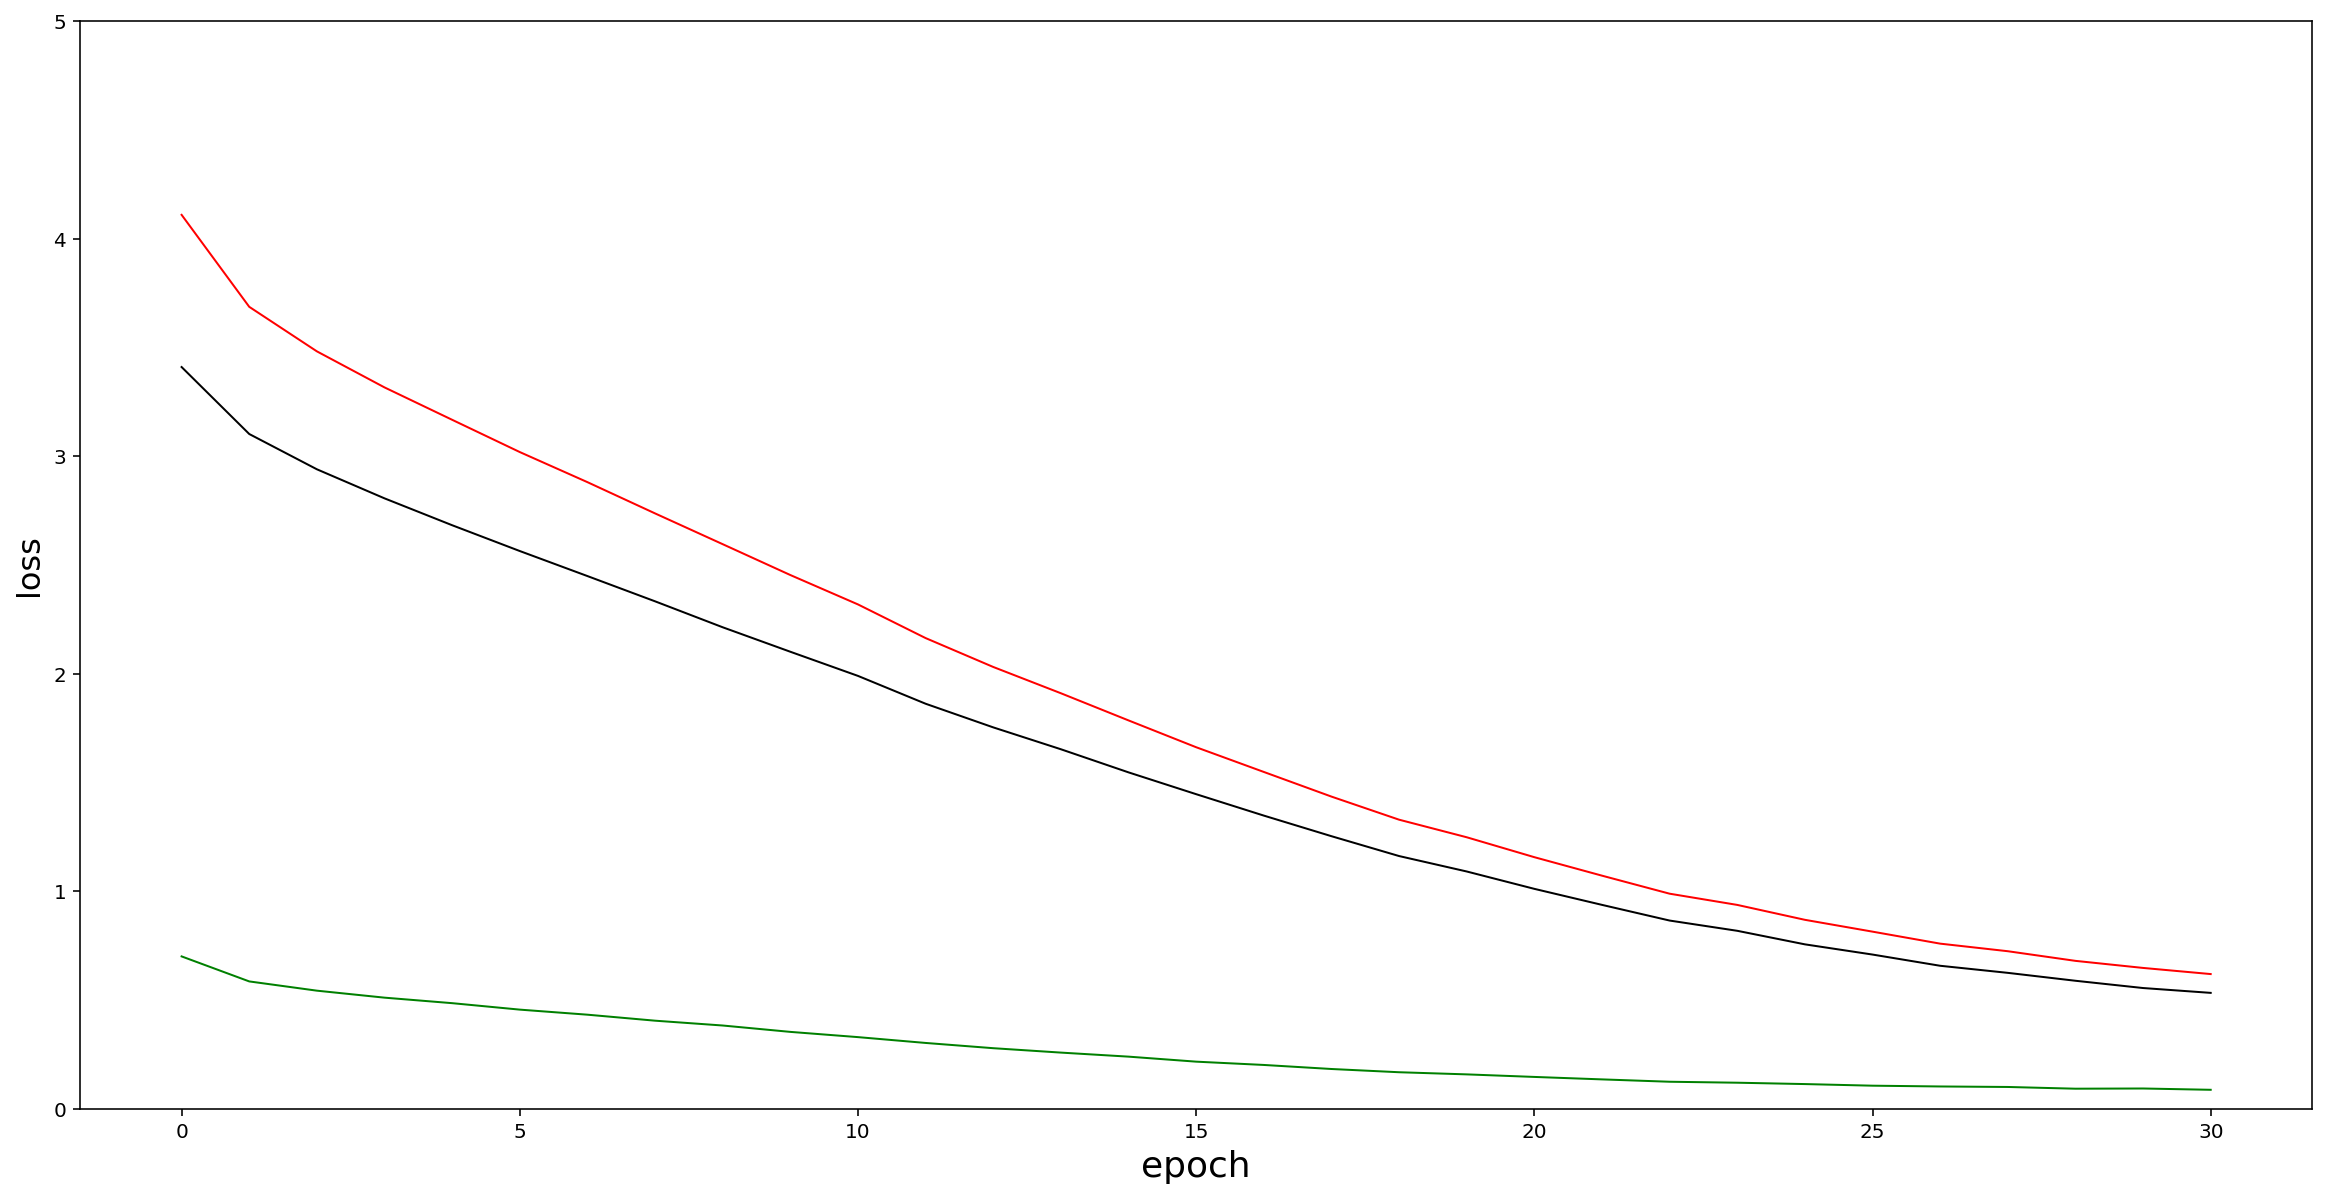

In [17]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in train_pitch_losses], color='black', linewidth=1)
plt.plot([x for x in train_duration_losses], color='green', linewidth=1)
plt.plot([x for x in train_losses], color='red', linewidth=1)

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.savefig(os.path.join(image_save_folder, 'train_loss_graph.png'))

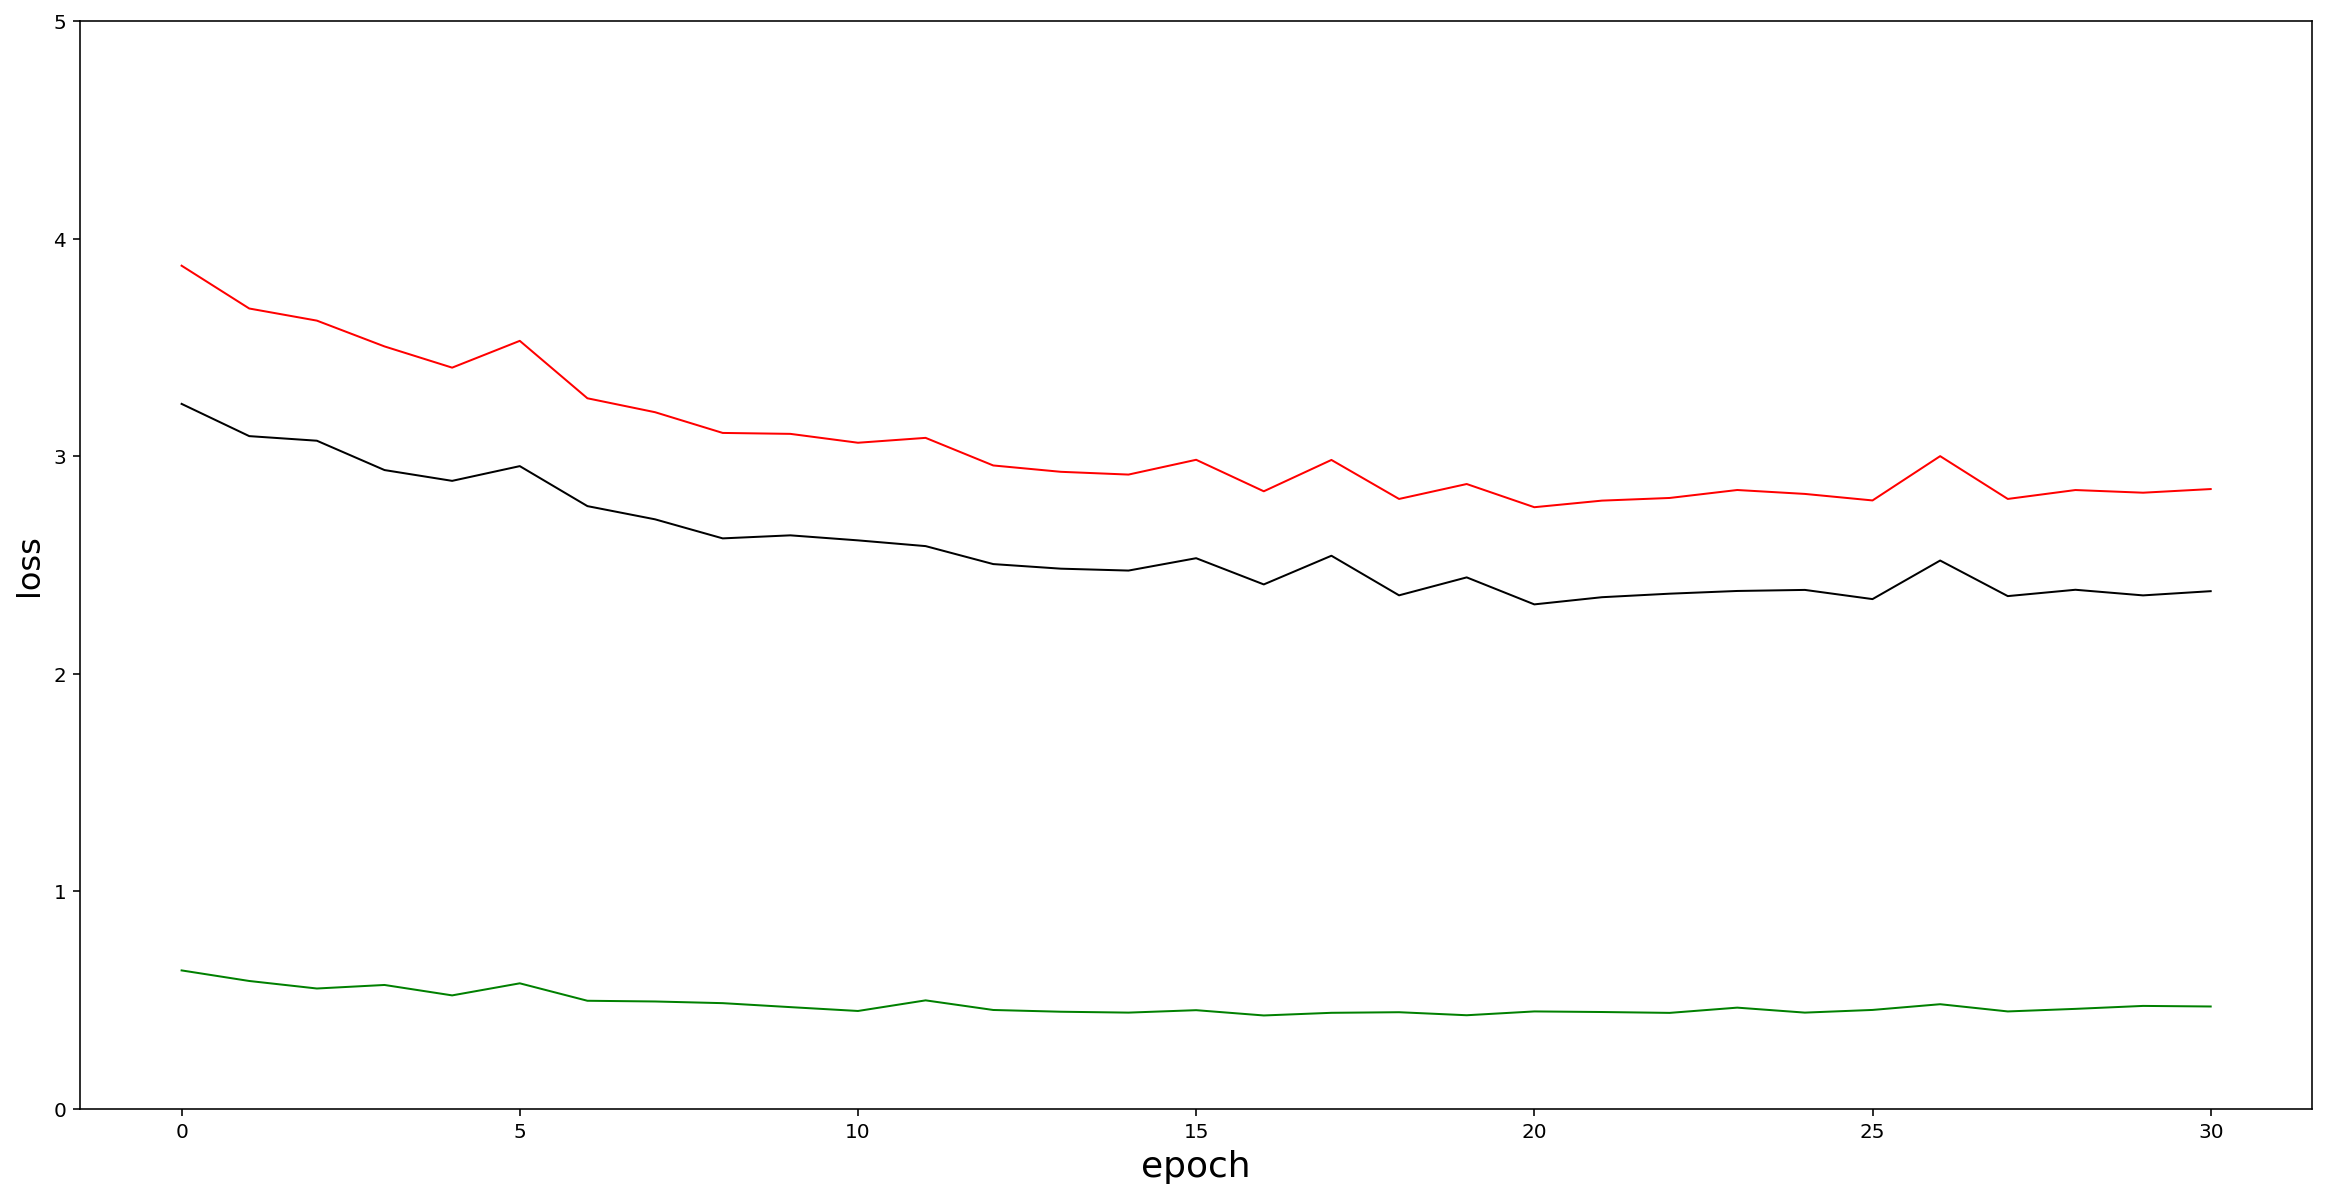

In [18]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in val_pitch_losses], color='black', linewidth=1)
plt.plot([x for x in val_duration_losses], color='green', linewidth=1)
plt.plot([x for x in val_losses], color='red', linewidth=1)

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.savefig(os.path.join(image_save_folder, 'val_loss_graph.png'))